# Schriftliche Ausarbeitung Learning & Softcomputing

### 1. Einleitung

Im Zentrum von Projekten zum Thema maschinelles Lernen stehen Daten. Oft ist der Erfolg von Projekten von der Qualität der zugrunde liegenden Daten abhängig. Das Problem welches man z.B. häufig im Kontext von ML-basierten Computer Vision Projekten hat, ist das keine passenden Datensätze zum eigene Kontext im Netz verfügbar sind oder das die Qualität/Anzahl der Daten sehr zu wünschen übrig lässt. 

Das führt dazu, dass man die Datensätze selber erstellen muss. Dies ist eine enorm aufwändiger Prozess, da die Bilder manuell gelabelt werden müssen. Abhilfe würde hier ein automatisierte Prozess zur synthetischen Datengenerierung schaffen. Das Thema der synthetischen Datengeneriung und das nutzen der synthethischen Daten um neuronale Netze zu trainieren ist das zentrale Thema dieser Arbeit. 

Das gesamte Thema wird im Anwendungskontext einer Verkehrsschild-Erkennung vorgestellt. 

Zunächst werden die verwendeten Technologien und die verwendeten Datensätze im Allgemeinen vorgestellt. Dann wird der Prozess der Erzeugung synthetischer Daten im Detail beschrieben. Im  darauf folgenden Teil wird die Trainingspipeline vorgestellt. Abschließend werden die Ergebnisse des Projekts evaluiert, bewertet und zusammengefasst. 

### 2. Entwicklungsumgebung und genutzte Technologien

Die Entwicklung fand hauptsächlich in Jupyter Notebooks statt, dies hat den Vorteil, die gesamte Arbeit im Anschluss besser dokumentieren zu können. Zudem wurde Python 3.8 genutzt. Als ML-Framework ist PyTorch (Version: 1.11) benutzt worden, welches ein weit verbreitetes Deep Learning Framework zum (unter anderem) erstellen, trainieren und ausführen von neuronalen Netzen ist.

### 3. Datensätze


#### 3.1 echter Datensatz

In diesem Projekt wurde sich für den LISA Traffic Sign Datensatz entschieden.

Der LISA Traffic Datensatz besteht aus. Dieser war jedoch beim Start des Projekts zunächst nicht auffindbar im Netz. Somit wurde sich im Rahmen des Projektes auf einen Auszug des LISA Traffic Datensatzes beschränkt. In diesem Auszug finden sich 900 Bilder mit entsprechenden Labels vor. Insgesamt sind 9 Schilder inkludiert, damit ergeben sich 100 Bilder pro Verkehrsschild. Das es sich nur um einen Auszug des eigentlichen LISA Datensatzes handelt, beinträchtigt die Aussagekraft der Ergebnisse nicht, da die Tatsache, einen sehr begrenzten Datensatz aus echten Daten zu haben, die Realität oft gut beschreibt.

Bei den Verkehrsschildern handelt es sich um die folgenden US-Amerikanischen Verkehrsschilder:
stop, yield, yieldAhead, merge, signalAhead, pedestrianCrossing, keepRight, speedLimit35 und speedLimit25

Hier einige Beispiel aus dem Datensatz:

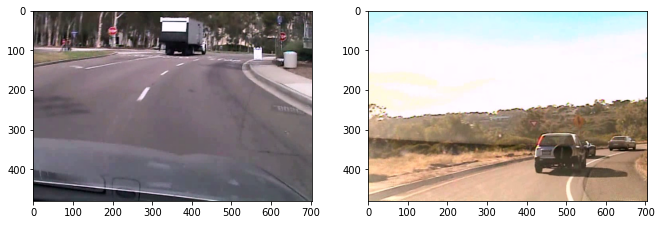

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

img_A = mpimg.imread('sample_001.png')
img_B = mpimg.imread('sample_356.png')


fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

Die Informationen zum Bild und die Labels sind in einer CSV-Datei gespeichert. Hier ein Auszug aus dieser Datei:

In [11]:
import pandas as pd
pd.read_csv("annotations.csv")

,filename,x1,y1,x2,y2,class
0,sample_001.png,190,40,211,63,stop
1,sample_002.png,4,246,43,283,stop
2,sample_003.png,389,286,418,314,stop
3,sample_004.png,307,243,315,251,stop
4,sample_005.png,377,249,398,270,stop
...,...,...,...,...,...,...
895,sample_896.png,534,155,563,187,speedLimit25
896,sample_897.png,526,223,540,240,speedLimit25
897,sample_898.png,633,236,663,269,speedLimit25
898,sample_899.png,407,273,431,300,speedLimit25


#### 3.1.1 Dataset Klasse

Das (Ver-)Arbeiten von/mit Datensätzen kann schnell unübersichtlich werden. Dabei bietet PyTorch die Möglichkeit, einen eigenen Datensatz auf Basis der DataSet-Klasse mit einzubinden. Dies ermöglicht unter anderem, dass der Code zur Verarbeitung des Datensatzes entkoppelt ist vom Code zum Training. Des Weiteren ermöglicht die Nutzung der Dataset-Klasse, die eigenen Daten in ein Format zu bringen, welches zum Training verschiedener neuronaler Netze ohne große Umstände genutzt werden kann. 

Bei der Nutzung des Datensatzes, müssen in der Dataset Klasse drei Funktionen definiert werden. 
1. __init__() 

Dabei wird init __init__() einmal bei der Instanziierung des Dataset-Objektes ausgeführt. Dabei findete die initialisierung des Verzechnis mit den Bildern, die Labeldatei und ggf. weiteren Transformationen statt. [Quelle]


2. __getitem__()

Die Funktion __getitem__() lädt eine Probe aus dem Datensatz mit dem angegebenen Index idx und gibt sie zurück. Anhand des Index identifiziert sie den Speicherort des Bildes auf der Festplatte, konvertiert es mit read_image in einen Tensor, ruft die entsprechende Bezeichnung aus den csv-Daten auf, ruft die Transformationsfunktionen für auf und gibt das Tensor-Bild und die entsprechende Bezeichnung in einem Tupel zurück. [Quelle]

3. __len__()

Die Funktion len() gibt die Anzahl der Sampels im verwendeten Datensatz wieder. [Quelle]


In [ ]:
class2id = {"stop": 1, "yield": 2, "yieldAhead": 3, "merge": 4, "signalAhead": 5, "pedestrianCrossing": 6, "keepRight": 7, "speedLimit35": 8, "speedLimit25":9}
# dataset definition
class myDataset(Dataset):
    # load the dataset
    def __init__(self,root,transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imgs"))))
        self.data = pd.read_csv(os.path.join(self.root, "annotations.csv"))
    # get a row at an index
    def __getitem__(self, idx):
        idx = idx -1
        img_path = os.path.join(self.root, "imgs", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        row = self.data.iloc[idx]
        
        boxes = []
        
        x1 = int(row[1])
        y1 = int(row[2])
        x2 = int(row[3])
        y2 = int(row[4])
        label = class2id[row[5]]
        boxes.append([x1, y1, x2, y2])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor([label], dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = torch.tensor([False])
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)

#### 3.2 Künstliche Daten
Das Hauptziel bei der Verwendung künstlicher Daten ist es, den Aufwand zur Erstellung der Daten im Vergleich zur Erstellung realer Daten so gering wie möglich zu halten. 
Mit der heutigen Technologie ist es zwar möglich, realistische Bilder zu erzeugen, die von einem Menschen kaum von realen Bildern zu unterscheiden sind, doch ist dies meist mit einem hohen Aufwand verbunden, so dass es oft einfacher wäre, direkt reale Daten zu verwenden.

Aus diesem Grund haben wir uns in diesem Projekt für einen anderen Ansatz entschieden. Anstatt komplette fotorealistische Szenen mit Straßenschildern zu rendern, beschränken wir uns darauf, nur einzelne Straßenschilder zu rendern, die dann in ein reales Hintergrundbild eingefügt werden.

### 4. Synthetische Bildgenerierung

#### 4.1 Schild Rendering

#### 4.1.1 Ausgangs Bilder

Um die Bilder der Straßenschilder zu generieren, verwenden wir svg-Dateien der entsprechenden Bilder aus [Wikipedia](https://en.wikipedia.org/wiki/Road_signs_in_the_United_States) als Grundlage. Einige von ihnen mussten leicht angepasst werden. Zum Beispiel gab es bei einigen Grafiken einen schwarzen Rand, der entfernt werden musste. Außerdem gab es nur eine Grafik für eine Geschwindigkeitsbegrenzung von 50 mph, so dass die 50 darauf durch eine 25/35 ersetzt werden musste.

#### 4.1.2 Rendering Engine

Wir haben uns für Blender als Rendering-Engine entschieden. Die Vorteile von Blender sind die umfangreiche Python-API und die verschiedenen Rendering-Optionen. Zwischenzeitlich hatten wir auch mit der Spiele-Engine Unity experimentiert. Hierbei stellten wir jedoch schnell fest dass es keine einfache Möglichkeit gibt, Bilder mit transparentem Hintergrund zu erstellen. Da dies für unseren Ansatz notwendig ist, haben wir entsprechend Blender eingesetzt.

#### 4.2 Randomisierung

Um viele verschiedene Bilder darstellen zu können, haben wir verschiedene Randomisierungsmöglichkeiten geschaffen. Bei der Wahl der Grenzen der Randomisierungsparameter haben wir uns nicht primär an der Realitätsnähe orientiert. Vielmehr war es das Ziel, die Parametergrenzen so zu setzen, dass sie den Bereich des real Möglichen möglichst weit abdecken. Die einzelnen Randomisierungsvarianten werden im Folgenden vorgestellt.

#### 4.3 Schild Rotation
Einer der wichtigsten Randomisierungsparameter ist die Drehung des Schildes relativ zur Kamera. Hier verwenden wir einen Winkel von +- 30° für die Gierachse und +-3° für die anderen Achsen. Wir sind davon ausgegangen, dass die Schilde und die Kamera normalerweise horizontal ausgerichtet sind, so dass nur die Gierachse eine größere Variation bietet. 

In [ ]:
def randRotation(obj, ranges):
    obj.rotation_euler = [randRange(ranges[0]) * deg2rad, randRange(ranges[1]) * deg2rad, randRange(ranges[2]) * deg2rad]

randRotation(self.sign, [(-3, 3), (-30, 30), (-3, 3)])

#### 4.4 Schild Position

Ein weiterer wesentlicher Parameter ist die Position des Schildes. Hier ist darauf zu achten, dass das Schild immer vollständig im Bild zu sehen ist. Aus diesem Grund kann die Position nicht einfach zufällig in einem Würfel gewählt werden. Vielmehr muss die Position im Sichtfeld der Kamera zufällig gewählt werden. Dazu wird im Koordinatensystem der Kamera eine Zufallsposition berechnet. Diese kann dann mit der inversen Projektionsmatrix multipliziert werden, um die Position im Weltkoordinatensystem zu erhalten. Ein Problem ist, dass die Transformation der Z-Position nicht linear ist. Um dennoch eine lineare Verteilung der Entfernung zur Kamera zu erhalten, muss dies entsprechend kompensiert werden. 

In [ ]:
def randPosInCam(objs, ranges, cam):
    for obj in objs:
        cam_mat = cam.matrix_world.inverted()
        proj_mat = cam.calc_matrix_camera(bpy.context.evaluated_depsgraph_get())
        mat = proj_mat @ cam_mat
        
        #proj_mat = np.reshape(np.array(list(proj_mat)))
        
        zpos = np.array([1, 0, randRange(ranges[2]), 1])
        zpos = np.reshape(np.array(list(proj_mat)), (4, 4)) @ zpos
        xpos = zpos[0] / zpos[3]
        zpos = zpos[2] / zpos[3]
        for i in range(2):
            ranges[i] = (ranges[i][0] + xpos, ranges[i][1] - xpos)
        pos = np.array([randRange(ranges[0]), randRange(ranges[1]), zpos, 1])
        pos = np.reshape(np.array(list(mat.inverted())), (4, 4)) @ pos
        pos = pos[0:3] / pos[3]
        for idx, p in enumerate(pos):
            obj.location[idx] = p

randPosInCam([self.sign], [(-1.0, 1.0), (-1.0, 1.0), (f*(-0.1), f*(-1.0))], self.cam)

#### 4.5 Schild Verunreinigung

Da Straßenschilder in der Regel keine perfekt sauberen Objekte sind, verwenden wir einige Texturen aus [AmbientCG]("https://ambientcg.com/view?id=OutdoorHDRI028"), die über einen mixed Shader mit der eigentlichen Schildtextur kombiniert werden. Dies erzeugt eine schmutzähnliche Struktur. Die Texturen werden zufällig aus dem Texturen-Ordner ausgewählt. Zusätzlich zur Textur wird auch die Stärke der Hintergrundtextur im Bereich zwischen 0% und 25% zufällig gewählt.

In [ ]:
def randBackgroundTex(mat, textures):
    mat.node_tree.nodes["Vector Math.001"].inputs[1].default_value[0] = random.random()
    mat.node_tree.nodes["Vector Math.001"].inputs[1].default_value[1] = random.random()
    scale = random.random()
    mat.node_tree.nodes["Vector Math"].inputs[1].default_value[0] = scale
    mat.node_tree.nodes["Vector Math"].inputs[1].default_value[1] = scale
    
    mat.node_tree.nodes["Mix"].inputs[0].default_value = random.random() * 0.25
    
    dir = os.path.join("textures", textures[random.randrange(0, len(textures))])
    for f in os.listdir(dir):
        if "NormalGL" in f:
            bpy.data.images["BackgroundNormal"].filepath = os.path.join("//" + dir, f)
            print("changed normal")
        elif "Color" in f:
            bpy.data.images["BackgroundColor"].filepath = os.path.join("//" + dir, f)
            print("changed color")
        else:
            print(f)

    #mat.node_tree.nodes["Vector Math.001"].inputs[2].default_value[0] = random.random()
    #mat.node_tree.nodes["Vector Math.001"].inputs[3].default_value[0] = random.random()

randBackgroundTex(self.mat, self.textures)

#### 4.6 Licht Position / Farbe / Stärke

Ein wichtiger Faktor für das Aussehen von Objekten ist der Lichteinfall. Da wir keine vollständige Szene rendern, wird die Lichtberechnung nie perfekt sein, da wir keine globalen Lichteffekte darstellen können. Um diese imitieren zu können, werden mehrere Lichtquellen geringerer Intensität verwendet, die zufällig um das Straßenschild herum positioniert werden. Neben der Position wird auch die Farbe der Lichtquellen variiert. Außerdem wird die Energie aller Lichtquellen zufällig in einem Bereich von 5 W bis 1000 W gewählt. Darüber hinaus wird die Stärke jeder Lichtquelle auch individuell durch die Farbe variiert. Das liegt daran, dass die Farbe wie ein Farbfilter wirkt, so dass eine dunklere Farbe zu einer geringeren Lichtleistung führt.

In [ ]:
def randPosition(obj, ranges):
    for idx, range in enumerate(ranges): 
        obj.location[idx] = randRange(range)

def randLightColor(obj):
    #obj = bpy.data.objects["test"].
    obj.data.color = [randRange((0, 1)), randRange((0, 1)), randRange((0, 1))]

def randObjColors(objs):
    for o in objs:
        randLightColor(o)
def setEnergy(objs, energy):
    for obj in objs:
        obj.data.energy = energy       

randPositions(self.lights, lightRanges)
randObjColors(self.lights)
setEnergy(self.lights, squareRandRange((5, 1000)))

#### 4.7 Bewegungsunschärfe

Ein wichtiger Effekt bei der Erkennung von Verkehrszeichen ist, dass die Bilder in der Regel aus einem fahrenden Auto aufgenommen werden. Das bedeutet, dass die Bewegungsunschärfe ein wichtiger Faktor ist. Um dies zu berücksichtigen, setzen wir die Kamera im 2. Frame der Animation in Blender auf eine zufällige Position, während sie im ersten Frame an der gleichen Stelle bleibt. Auch wenn wir jeweils nur das erste Bild rendern, reicht dies für Blender, die Bewegungsunschärfe anhand der Differenz zwischen dem ersten und zweiten Frame zu berechnen.

In [ ]:

        
def randCameraPos(cam):
    cam.location = [0, 0, 5]
    cam.keyframe_insert(data_path="location", frame=1)
    randPosition(cam, [(-0.5, 0.5), (-0.5, 0.5), (1.5, 9.5)])
    cam.keyframe_insert(data_path="location", frame=2)
    cam.location = [0, 0, 5]

randCameraPos(self.cam)

#### 4.8 Bild erzeugung

Für die eigentliche Bilderstellung werden alle Schildtexturen im Ordner Signs nacheinander geladen und für jedes Schild 250 Bilder gerendert. Um später die Position des Zeichens im Bild bestimmen zu können, wird die Zeichenposition in Matrixform in einer separaten Datei zusätzlich zum eigentlichen Bild gespeichert.

Beispiel Bild 1

![alt text](Doku/Stop_0_112.png "Stop Sign Example")

Beispiel Bild 2

![alt text](Doku/Stop_0_131.png "Stop Sign Example")

Beispiel Bild 3

![alt text](Doku/Stop_0_164.png "Stop Sign Example")

Beispiel Bild 4

![alt text](Doku/Stop_0_218.png "Stop Sign Example")

Beispiel Schildposition:

[[3.4865732192993164, 0.007074987981468439, -1.5570251941680908, 24.646499633789062], [-0.022177748382091522, 3.8182499408721924, -0.03231178596615791, 1.3422151803970337], [-0.408542662858963, -0.01011506374925375, -0.9148762226104736, 39.730533599853516], [-0.4077264070510864, -0.010094854049384594, -0.9130483269691467, 39.8509521484375]]

#### 4.9 Fake_Dataset

Um eine möglichst große Vielfalt an Bildern zu erhalten, wird die endgültige Bildkomposition erst zur Trainingszeit durchgeführt. Zunächst wird ein zufälliges Hintergrundbild ausgewählt. Für die Hintergrundbilder werden die Bilder aus dem [COCO-Validierungsset]("https://cocodataset.org/#download") von 2017 verwendet. 

Dann wird eine zufällige Anzahl von Zeichen in das ausgewählte Bild eingefügt. Anschließend werden die Bounding Boxes für diese Zeichen berechnet. Zusätzlich wird für jedes neue Zeichen geprüft, ob es ein bestehendes Zeichen überdeckt, und wenn ja, wird dieses Zeichen ausgelassen. 

Außerdem werden die Zeichen teilweise mit einer leichten Transparenz versehen, bevor sie eingefügt werden. Die Idee dazu kam uns vor allem durch Bilder aus dem realen Datensatz, bei denen das Schild teilweise durch Spiegelungen in der Windschutzscheibe verdeckt wird.

Bei der Untersuchung der Ergebnisse haben wir auch festgestellt, dass es sehr wichtig ist, das endgültige Bild als jpg zu kodieren und wieder zu dekodieren, da sich gezeigt hat, dass die Modelle sonst lernen, nicht komprimierteTeile auf einem komprimierten Hintergrund zu finden.

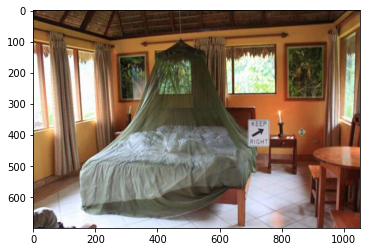

In [2]:
from datetime import MAXYEAR
import random 
from torch.utils.data import Dataset
import os
import cv2 as cv
from PIL import Image
import numpy as np
import torch as torch
import json
from matplotlib import pyplot as plt

def bb_union(bb1, bb2):
    minx1, miny1, maxx1, maxy1 = bb1
    minx2, miny2, maxx2, maxy2 = bb2
    minx, miny, maxx, maxy = max(minx1, minx2), max(miny1, miny2), min(maxx1, maxx2), min(maxy1, maxy2)
    if maxx < minx or maxy < miny:
        return 0, 0, 0, 0
    return minx, miny, maxx, maxy
def bb_area(bb):
    minx, miny, maxx, maxy = bb
    return (maxx - minx) * (maxy - miny)
def bb_oclusion(bb1, bb2):
    return bb_area(bb_union(bb1, bb2)) / min(bb_area(bb1), bb_area(bb2))

class fake_dataset(Dataset):
    def __init__(self, sign_path: str, background_path: str, length: int, 
                 scr: tuple[int, int], size: int, sign_sice: tuple[int, int], transforms = None):
        self.sign_path = sign_path
        self.background_path = background_path
        self.signs = os.listdir(os.path.join(sign_path, "imgs"))
        self.backgrounds = os.listdir(background_path)
        self.length = length
        self.scr = scr
        self.sign_size = sign_sice
        self.transforms = transforms
        self.name2label = {"Stop": 1, "Yield": 2, "YieldAhead": 3, "Merge": 4, "TrafficLightAhead": 5, "PedestrianCrossing": 6, "KeepRight": 7, "MaxSpeed35": 8, "MaxSpeed25": 9}
        self.edge_points = {1: [np.array([0.4, 1, 0, 1]), np.array([-0.4, 1, 0, 1]), np.array([0.4, -1, 0, 1]), np.array([-0.4, -1, 0, 1]),
                                np.array([1, 0.4, 0, 1]), np.array([1, -0.4, 0, 1]), np.array([-1, 0.4, 0, 1]), np.array([-1, -0.4, 0, 1])],
                            2: [np.array([-1, 1, 0, 1]), np.array([1, 1, 0, 1]), np.array([0, -1, 0, 1])],
                            3: [np.array([1, 0, 0, 1]), np.array([-1, 0, 0, 1]), np.array([0, 1, 0, 1]), np.array([0, -1, 0, 1])],
                            4: [np.array([1, 0, 0, 1]), np.array([-1, 0, 0, 1]), np.array([0, 1, 0, 1]), np.array([0, -1, 0, 1])],
                            5: [np.array([1, 0, 0, 1]), np.array([-1, 0, 0, 1]), np.array([0, 1, 0, 1]), np.array([0, -1, 0, 1])],
                            6: [np.array([1, 0, 0, 1]), np.array([-1, 0, 0, 1]), np.array([0, 1, 0, 1]), np.array([0, -1, 0, 1])],
                            7: [np.array([1, 1, 0, 1]), np.array([-1, 1, 0, 1]), np.array([1, -1, 0, 1]), np.array([-1, -1, 0, 1])],
                            8: [np.array([1, 1, 0, 1]), np.array([-1, 1, 0, 1]), np.array([1, -1, 0, 1]), np.array([-1, -1, 0, 1])],
                            9: [np.array([1, 1, 0, 1]), np.array([-1, 1, 0, 1]), np.array([1, -1, 0, 1]), np.array([-1, -1, 0, 1])],}
        self.size = size
    def get_rand_img(root, paths) -> np.ndarray:
        path = paths[random.randrange(0, len(paths))]
        img = cv.imread(os.path.join(root, path), cv.IMREAD_UNCHANGED)
        if len(img.shape) == 2:
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        if (img.shape[2] == 3):
            img = img[:,:,[2, 1, 0]]
        elif (img.shape[2] == 4):
            img = img[:,:,[2, 1, 0, 3]]
        else:
            assert False
        return img, path
    def sign_path2label(self, path:str):
        return self.name2label[path.split("_")[0]]
    def get_bb(self, path: str, id: int, img_shape):
        with open(os.path.join(self.sign_path, "info", path.replace(".png", ".info.json"))) as jf:
            minx = 100000
            maxx = 0
            miny = 100000
            maxy = 0
            mat = json.load(jf)
            mat = np.array(mat)
            for point in self.edge_points[id]:
                point = mat @ point                
                point = point[0:2] / point[3]
                #point[1] *= -1
                point = point * 0.5 + 0.5
                point[0] *= img_shape[1]
                point[1] *= img_shape[0]
                point[1] = img_shape[0] - point[1]
                minx = min(minx, point[0])
                maxx = max(maxx, point[0])
                miny = min(miny, point[1])
                maxy = max(maxy, point[1])
            return int(minx), int(miny), int(maxx), int(maxy)
    def blockout(alpha, bbox):
        if (bbox[2] - bbox[0]) // 4 > 0 and (bbox[3] - bbox[1]) // 4 > 0:
            for i in range(random.randrange(0, 5)):
                w = random.randrange(0, (bbox[2] - bbox[0]) // 4)
                h = random.randrange(0, (bbox[3] - bbox[1]) // 4)
                x = random.randrange(bbox[0], bbox[2] - w)
                y = random.randrange(bbox[1], bbox[3] - h)
                cv.rectangle(alpha, (x, y), (x+w, y+h), 0, -1)
        return alpha
    def __len__(self) -> int:
        return self.length
    def __getitem__(self, idx):
        sign_count = random.randrange(self.scr[0], self.scr[1])
        img, path = fake_dataset.get_rand_img(self.background_path, self.backgrounds)
        boxes = []
        labels = []
        area = []
        x = self.size / min(img.shape[0], img.shape[1])
        img = cv.resize(img, (0, 0), fx = x, fy = x)
        ocluded_box_count = 0
        for i in range(sign_count):
            sign, path = fake_dataset.get_rand_img(os.path.join(self.sign_path, "imgs"), self.signs)
            size = random.randrange(self.sign_size[0], min(img.shape[0]-5, img.shape[1]-5, self.sign_size[1]))
            scaling = size / max(sign.shape)
            sign = cv.resize(sign, dsize=(0, 0), fx=scaling, fy=scaling)
            minx, miny, maxx, maxy = self.get_bb(path, self.sign_path2label(path), sign.shape)
            
            w = sign.shape[1]
            h = sign.shape[0]
            
            x = random.randrange(0, img.shape[1] - sign.shape[1])
            y = random.randrange(0, img.shape[0] - sign.shape[0])
            bbox_img = (x+minx, y+miny, x+maxx, y+maxy)
            ocluded = False
            # Prevent oclusion
            for box in boxes:
                b = box[0], box[1], box[2], box[3]
                if bb_oclusion(b, bbox_img) > 0.1:
                    
                    ocluded = True
                    ocluded_box_count += 1
                    break
            if ocluded:
                continue
            alpha = (sign[:,:,3]/255)
            
            #alpha = fake_dataset.blockout(alpha, bbox)

            #alpha *= (random.random() * 0.25 + 0.75)
            alpha = np.stack([alpha, alpha, alpha], axis=-1)
            sign = sign[:,:,0:3] * alpha
            img[y:y+h, x:x+w, :] = img[y:y+h, x:x+w, :] * (1-alpha) + sign
            
            boxes.append(np.array([x+minx, y+miny, x+maxx, y+maxy]))
            labels.append(self.sign_path2label(path))
            area.append(w*h)
        target = {"boxes": torch.tensor(np.stack(boxes), dtype=torch.float32), 
                  "labels": torch.tensor(labels, dtype=torch.int64),
                  "image_id": torch.tensor([idx], dtype=torch.int64),
                  "area": torch.tensor(area, dtype=torch.float32),
                  "iscrowd": torch.tensor([False] * (sign_count - ocluded_box_count)),
                  }
        encode_params = [cv.IMWRITE_JPEG_QUALITY, random.randrange(5, 75)]
        #cv.imdecode()
        buf = cv.imencode(".jpg", img, encode_params)
        #print(buf)
        img = cv.imdecode(buf[1], cv.IMREAD_UNCHANGED)
        img = Image.fromarray(img)
        # = np.transpose(img, (2, 0, 1))
        #img = torch.tensor(img, dtype=torch.float32) / 255
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

dataset_train_ = fake_dataset("blender/out", "backgrounds_coco", 1000, (2, 5), 700, (300, 600))
img, target = dataset_train_.__getitem__(0)
plt.figure()
plt.imshow(img)
plt.show()

### 5. Trainingspipeline
Im Folgenden wird der grundsätzliche Aufbau der Trainingspipeline beschrieben. Dieser baut auf das von Pytorch.org vorgegeben Beispiel "_Torchvision object detection finetuning tutorial_" auf.

Zunächst werden die gewünschten Transformationsoperationen definiert. Dabei wird __PILtoTensor__()  (Zeile 5)und
__Normalize__() (Zeile 6) angewendet.
Bei der __PILtoTensor__() Funktion wird wie der Funktionsname schon sagt ein Bild im __PIL__-Format (H x W x C) in einen __Tensor__ (C x H x W) überführt. Durch das __Normalize__() wird das Tensorbild normalisiert.

Spezifisch könnten dann noch speziell für das Training Transformationen definiert werden. Hier findet noch das __RandomHorizontalFlip__() (Zeile 9) Anwendung.

In [ ]:
import detection.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.Normalize())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In diesem Schritt wird der Datensatz mittels der Dataset-Klasse initialisiert. Für das __dataset_train__ wird das 'train' auf True gesetzt, da hier die eben besprochenen __RandomHorizontalFlip__() Funktion auf die Trainingsdaten angewendet werden soll (Zeile 1-2).
Anschließend wird festgelegt das 950 Bilder zum Trainineren und 50 Bilder zum Testen genutzt werden sollen. Davor ist duch das __torch.randperm(len(dataset)).tolist()__
für eine anschließend zufällige Verteilung der Daten gesorgt wurden (Zeile 4-6).


In [ ]:
dataset_train = myDataset('db_lisa_tiny', get_transform(train=True))
dataset_test = myDataset('db_lisa_tiny', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In diesem Schritt werden die Datasets in __Dataloader__ geladen. Da es sich bei dem Dataloader um ein Iterable handelt, erleichert dies im Training über die Datenpunkte zu iterieren. (Zeile 1-3)

In [ ]:
import detection.utils as utils
data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

In diesem Teil werden weitere Paramtereinstellungen vorgenommen. In Zeile 1 und 7 wird festgelegt, dass das Training (wie üblicherweise sinnvoll) auf einer GPU auf der Cuda läuft ausgeführt werden soll und falls dies nicht der Fall ist auf der CPU trainiert werden soll.

Im Zeile 9-10 wird der Optimizer konstruiert. Dabei soll im Training das Stochastic Gradient Descent (SGD) Verfahren zum Einsatz kommen. Zudem kommt ein Learningrate-Scheduler zum Einsatz. Dabei wird die Lernrate nach jeweils 3 Epochen umd das vordefinierte Gamma angepasst (Zeile 12).

Zudem ist hier die Anzahl der Epochen in denen trainiert wird auf 8 gesetzt. Dieser Wert wurde jedoch für unterschiedliche Trainingsdurchläufe verändert, wie in der Evaluation zu sehen sein wird.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 9

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn()

model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

num_epochs = 8


In diesem Teil findet das eigentliche Training und einer erster Schritt zur Evaluation statt. Dafür wird auf die Funktion __train_one_epoch__() welche dann je nach gewählter Epochenanzahl entsprechend oft ausgeführt wird. Dieser Funktion wird das Modell, der Optimizer, der Dataloder (also der Trainingsdatensatz), das Device, die epoche und die Ausgabefrequenz der Zwischenergebnisse übergeben. Bei __train_one_epoch__() handelt es sich um eine Funktion die in engine.py hinterlegt ist. Diese ist im Git-Repo im Ordner _detection_ zu finden. In Zeile 9 findet dann eine erste Evaluation auf Basis der Testdaten statt. In der Ausgabe ist zu sehen wie die gängigen Metriken mit ausgegeben werden. 

In [ ]:
from detection.engine import train_one_epoch, evaluate

for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/425]  eta: 0:01:52  lr: 0.000017  loss: 5.1665 (5.1665)  loss_classifier: 4.4604 (4.4604)  loss_box_reg: 0.0058 (0.0058)  loss_objectness: 0.6925 (0.6925)  loss_rpn_box_reg: 0.0077 (0.0077)  time: 0.2648  data: 0.0320  max mem: 1173

Epoch: [0]  [ 10/425]  eta: 0:00:54  lr: 0.000135  loss: 5.1535 (5.1243)  loss_classifier: 4.4479 (4.4153)  loss_box_reg: 0.0068 (0.0113)  loss_objectness: 0.6939 (0.6937)  loss_rpn_box_reg: 0.0036 (0.0041)  time: 0.1317  data: 0.0229  max mem: 1238

Epoch: [0]  [ 20/425]  eta: 0:00:50  lr: 0.000252  loss: 4.9589 (4.8708)  loss_classifier: 4.2498 (4.1623)  loss_box_reg: 0.0072 (0.0104)  loss_objectness: 0.6929 (0.6933)  loss_rpn_box_reg: 0.0038 (0.0048)  time: 0.1170  data: 0.0221  max mem: 1238

Epoch: [0]  [ 30/425]  eta: 0:00:47  lr: 0.000370  loss: 3.4360 (3.9298)  loss_classifier: 2.7280 (3.2239)  loss_box_reg: 0.0075 (0.0097)  loss_objectness: 0.6914 (0.6914)  loss_rpn_box_reg: 0.0048 (0.0048)  time: 0.1152  data: 0.0226  max mem: 1238

Epoch: [0]  [ 40/425]  eta: 0:00:45  lr: 0.000488  loss: 0.8448 (3.1716)  loss_classifier: 0.1656 (2.4690)  loss_box_reg: 0.0113 (0.0119)  loss_objectness: 0.6789 (0.6856)  loss_rpn_box_reg: 0.0053 (0.0052)  time: 0.1131  data: 0.0222  max mem: 1238

Epoch: [0]  [ 50/425]  eta: 0:00:44  lr: 0.000606  loss: 0.7780 (2.7021)  loss_classifier: 0.1053 (2.0103)  loss_box_reg: 0.0142 (0.0133)  loss_objectness: 0.6418 (0.6731)  loss_rpn_box_reg: 0.0064 (0.0054)  time: 0.1121  data: 0.0219  max mem: 1238

Epoch: [0]  [ 60/425]  eta: 0:00:42  lr: 0.000724  loss: 0.7234 (2.3690)  loss_classifier: 0.0989 (1.6958)  loss_box_reg: 0.0102 (0.0127)  loss_objectness: 0.5879 (0.6548)  loss_rpn_box_reg: 0.0061 (0.0057)  time: 0.1136  data: 0.0216  max mem: 1238


### 6. Auswertung

Um die Qualität der Daten zu bestimmen, wurde ein Objekterkennungsmodell Trainiert und auf einem Teil des Lisa-Datensatzes ausgewertet. Hierbei wurden die einzelnen Komponenten der Verlustfunktion sowie spezielle Bewertungsmetriken nach jeder Epoche gespeichert.

Das primär verwendete Modell, Faster RCNN, verwendet einen zweiteiligen Ansatz. Zunächst werden in einem Region Proposal Schritt Regionen ermittelt, in denen Objekte vorhanden sind. Die Größe der Region wird über eine Regression grob an das Objekt angepasst. In einem zweiten Schritt werden die einzelnen Regionen klassifiziert und die Größe der Bounding Box so genau wie möglich bestimmt. Daraus ergeben sich die folgenden Verlustwerte:

1. Objektness -> Wie gut ist die Bestimmung von Regionen, die Objekte enthalten?
2. RPN Box Regression -> Die Genauigkeit der Bounding Box im Region Proposal Schritt.
3. Classification -> Genauigkeit der eigentlichen Klassifikation.
4. Box Regression -> Genauigkeit der finalen Bounding Box.

Darüber hinaus wurden Metriken auf der Grundlage der COCO-Bewertungsmetriken berechnet.
Dazu gehören die Mean Average Presision und der Mean Average Recall, d.h. die durchschnittliche Sensitivität und Spezifität über alle Klassen hinweg. Zur Bestimmung der Korrektheit einer Erkennung wird der sogenannte IoU-Score verwendet. Dies steht für Intersection over Union und ist ein Maß für die Überlappung von Bounding Boxes. Als Grenzwerte für den IoU wurden Werte von 0,5, 0,75 sowie der Durchschnitt über die Grenze 0,5 ... 0,95 (Schrittweite 0,05) ausgewertet.
Aus Zeitgründen haben wir die Boundingboxen im synthetischen Datensatz nicht für alle Zeichen mit exakter Genauigkeit gelabelt, sodass sich die Auswertung auf eine IoU-Grenze von 0,5 beschränkt.

#### 6.1 Verschiedene Experimente
![alt text](Doku/Precision-Recall.png "Presicion und Recall verschiedener Fake Datensätze und des Realen Datensatzes, IoU Grenzwert: 0.5")

In der obigen Grafik sind die verschiedenen Versuche in chronologischer Reihenfolge von links nach rechts angeordnet. Hier fällt auf, dass die ersten Versuche bereits Ergebnisse erzielen, die besser sind als bei einer Zufallsverteilung zu erwarten wäre, aber immer noch auf einem sehr niedrigen Niveau im Vergleich zu einem mit realen Daten trainierten Netz liegen. Trotz verschiedener Versuche, dies zu verbessern, führten die von uns vorgenommenen Änderungen zunächst zu keiner nennenswerten Verbesserung. Das änderte sich erst, nachdem wir die fertigen Bilder zusätzlich in jpg kodiert und wieder dekodiert hatten. Allein dieser Schritt hat bereits zu einer deutlichen Verbesserung geführt. Wir vermuten, dass dies darauf zurückzuführen ist, dass wir bei der Bilderzeugung unkomprimierte Bilder in ein komprimiertes Hintergrundbild einfügen. Das Netz lernt dann, zwischen komprimierten und nicht komprimierten Bildteilen zu unterscheiden, anstatt nach Verkehrszeichen zu suchen.
Der letzte große Leistungssprung ist darauf zurückzuführen, dass einige zufällige Variationen bei der Generierung von Verkehrszeichen zur Fehlersuche deaktiviert wurden. Da deren Aktivierung zu einer weiteren signifikanten Verbesserung führte, kann davon ausgegangen werden, dass sie grundsätzlich einen positiven Einfluss auf die Erkennungsgenauigkeit haben.

#Objectness Loss
![alt text](Doku/loss_objectness.png "Entwicklung des Objectness Losses für das Training mit echten und mit künstlichen Daten.")

Wie in der obigen Grafik zu sehen ist, wird die Annahme, dass das Modell lernt, nicht komprimierte Teile des Bildes zu erkennen, auch durch die Entwicklung des Objektivitätsverlustes unterstützt. Nachdem das Bild zusätzlich komprimiert wurde, sank der Objektivitätsverlust deutlich. Dies zeigt, dass durch die Kompression die Entscheidung, ob ein Bildteil ein Objekt enthält, in realen und künstlichen Daten ähnlicher geworden ist.

#### 6.2 Verschiedene Größen
![alt text](Doku/Different-Sizes.png "Auswertung für verschieden Große Objekte")
Beim Vergleich der Erkennungsleistung zwischen echten und unechten Daten für verschiedene Objektgrößen fällt auf, dass der Leistungsverlust mit gefälschten Daten bei kleinen Objekten deutlich stärker ausgeprägt ist als mit echten Daten. Das geht so weit, dass die Leistung mit gefälschten Daten bei großen Objekten sogar besser ist als die mit echten Daten. Dies ist unerwartet, da wir nicht erwartet hatten, dass eine einfache Verkleinerung der Bilder diese "unrealistischer" machen würde. Eine mögliche Erklärung dafür könnte sein, dass Bildartefakte wie Komprimierung, Bildrauschen usw. einen viel größeren Einfluss auf kleine Objekte haben. Darüber hinaus könnte es sein, dass bei kleinen Objekten mehr Kontextinformationen, d. h. die Position des Objekts im Verhältnis zu anderen Objekten, eine Rolle spielen. Weitere Forschungen in diesem Bereich könnten hier Aufschluss geben.  

### 7. Zusammenfassung
Alles in allem lässt sich sagen, dass das Training mit künstlich erzeugten Bildern in der Objekterkennung recht vielversprechend ist. Innerhalb kurzer Zeit konnten wir eine Pipeline aufbauen, die es ermöglicht, jede Art von Verkehrschild zu trainieren, selbst dann wenn sie in der Realität noch nicht existiert.
Besonders für große Objekte ist dieser Ansatz sehr gut geeignet, allerdings nimmt die Leistung bei kleineren Objekten stark ab.

Wir haben auch festgestellt, dass Artefakte, die für den Menschen kaum wahrnehmbar sind, z.B. durch Kompression, einen sehr großen Einfluss auf die Erkennungsleistung haben können. Es ist daher unerlässlich, diese bei der künstlichen Datengenerierung zu berücksichtigen.

#### 7.1 Beispiele Detection Fake - Modell

![alt text](Doku/fake-echt1.png "Beispiel von Detektionen eines mit künstlichen Daten Trainierten Modelles auf echten Daten")
![alt text](Doku/fake-echt2.png "Beispiel von Detektionen eines mit künstlichen Daten Trainierten Modelles auf echten Daten")
![alt text](Doku/fake-echt3.png "Beispiel von Detektionen eines mit künstlichen Daten Trainierten Modelles auf echten Daten")
![alt text](Doku/fake-echt4.png "Beispiel von Detektionen eines mit künstlichen Daten Trainierten Modelles auf echten Daten")
![alt text](Doku/fake-echt5.png "Beispiel von Detektionen eines mit künstlichen Daten Trainierten Modelles auf echten Daten")